## 0. Importing Necessary Libraries & Dependencies

In [29]:
# Importing Libraries
import torch
from torch import nn

print(f"PyTroch Version: {torch.__version__}")

# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

PyTroch Version: 2.5.1
Device: cpu


In [30]:
!nvidia-smi # if you have a gpu

zsh:1: command not found: nvidia-smi


## 1. Get Data

In [31]:
import requests
import zipfile
from pathlib import Path

# Set up path to datafolder
data_path = Path("data/")
image_data_path = data_path / "fruits_dataset"

# If the fruits_dataset folder doesn't exists, download it and prepare it.....
if image_data_path.is_dir():
  print(f"{image_data_path} directory already exists! Skipping download......")
else:
  print(f"{image_data_path} doesn't exists, creating one......")
  image_data_path.mkdir(parents=True, exist_ok=True)

# Download fruits_dataset
with open(data_path / "fruits_dataset.zip", "wb") as f:
  request = requests.get("https://github.com/nepal-manjil32/pytorch-models/raw/main/datasets/fruits_dataset.zip")
  print("Downloading fruits_classification dataset......")
  f.write(request.content)

# Unzip fruits_classification dataset
with zipfile.ZipFile(data_path / "fruits_dataset.zip", "r") as zip_ref:
  print("Unzipping fruits_dataset.zip......")
  zip_ref.extractall(image_data_path)

data/fruits_dataset directory already exists! Skipping download......
Unzipping fruits_dataset.zip......


## 2. Data Exploaration & Preparation

In [32]:
import os
def wal_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)}images in '{dirpath}")

wal_through_dir(image_data_path)

There are 2 directories and 0images in 'data/fruits_dataset
There are 1 directories and 0images in 'data/fruits_dataset/__MACOSX
There are 2 directories and 3images in 'data/fruits_dataset/__MACOSX/fruits_dataset
There are 10 directories and 10images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test
There are 0 directories and 89images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/apple
There are 0 directories and 105images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/avocado
There are 0 directories and 103images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/stawberries
There are 0 directories and 105images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/kiwi
There are 0 directories and 105images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/pinenapple
There are 0 directories and 105images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/cherry
There are 0 directories and 105images in 'data/fruits_dataset/__MACOSX/fruits_dataset/test/watermelon


In [33]:
# Setup training and testing paths
train_dir = image_data_path / "__MACOSX/train"
test_dir = image_data_path / "__MACOSX/test"

train_dir, test_dir

(PosixPath('data/fruits_dataset/__MACOSX/train'),
 PosixPath('data/fruits_dataset/__MACOSX/test'))

### 2.1 Visualization

In [34]:
image_data_path

PosixPath('data/fruits_dataset')

Random Image Path: data/fruits_dataset/fruits_dataset/train/mango/img_1241.jpeg
Image Class: mango
Image Height: 275
Image Width: 183


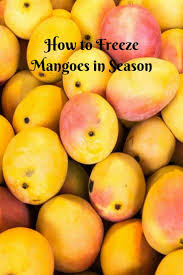

In [35]:
##-- Visualizing using PIL --##
import random
from pathlib import Path
from PIL import Image

random.seed(42)

# 1. Get all image paths
image_path_list = list(image_data_path.glob("*/*/*/*.jpeg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get the image class from the path name
image_class = random_image_path.parent.stem

# 4. Open the image
img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

(np.float64(-0.5), np.float64(182.5), np.float64(274.5), np.float64(-0.5))

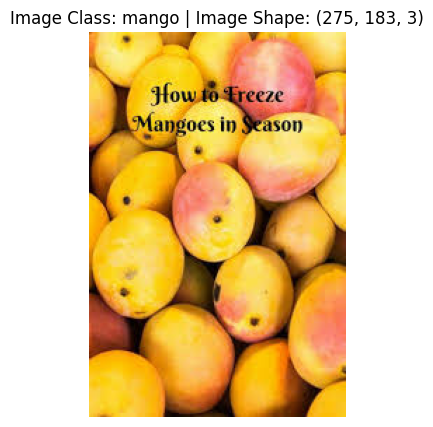

In [36]:
##-- Visulaizing using matplotlib --##
import numpy as np
import matplotlib.pyplot as plt

# Turn the images into an array
img_as_array = np.asarray(img)

plt.figure(figsize=(6,5))
plt.imshow(img_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {img_as_array.shape}")
plt.axis(False)

## 3. Transforming Data

In [37]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [38]:
##-- Image transformation script --##
train_image_transform = transforms.Compose([
    transforms.Resize(size=(227, 227)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_image_transform = transforms.Compose([
    transforms.Resize(size=(227, 227)),
    transforms.ToTensor()
])

In [39]:
transformed_image = train_image_transform(img)

In [40]:
##-- Function to visualize original and transformed image --##
def plot_transformed_image(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for img_pth in random_image_paths:
    with Image.open(img_pth) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\n{f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1,2,0) # [color_channels, height, width] -> [height, width, color_channels]
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\n{transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {img_pth.parent.stem}", fontsize=16)

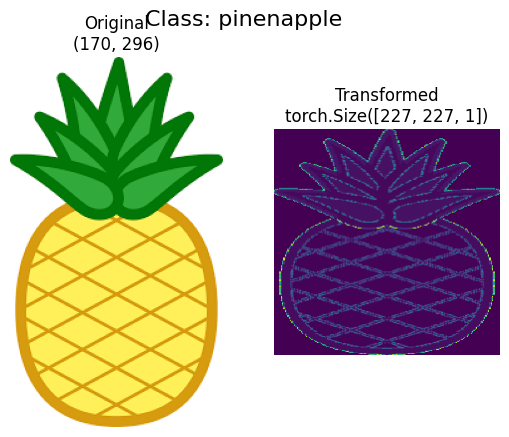

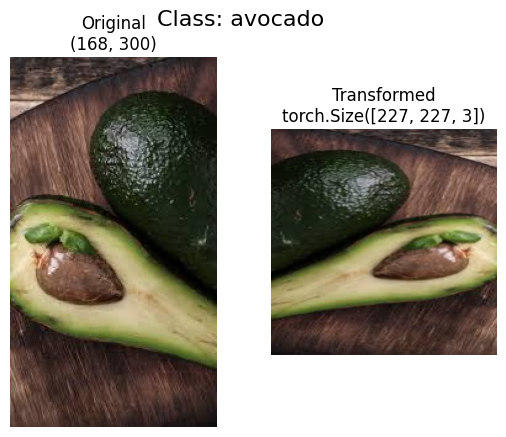

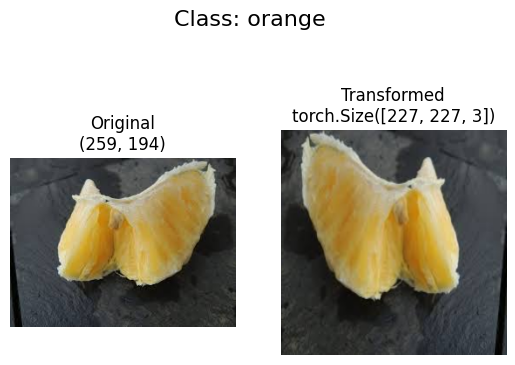

In [41]:
plot_transformed_image(image_paths=image_path_list, transform=train_image_transform, n=3)

## 4. Loading Image Data Using ImageFolder

We can load image classification data uing `torch.vision.datasets.ImageFolder`

**Note: **Since our dataset in the standard image classification format, we can use one of `torchvision.datasets` prebuilt functions

In [42]:
# _MACOSX is causing error and the actual path appears like this
train_dir = 'data/fruits_dataset/fruits_dataset/train'
test_dir = 'data/fruits_dataset/fruits_dataset/test'

In [43]:
train_dir, test_dir

('data/fruits_dataset/fruits_dataset/train',
 'data/fruits_dataset/fruits_dataset/test')

In [44]:
# Using ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_image_transform,
                                  target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_image_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 2301
     Root location: data/fruits_dataset/fruits_dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1025
     Root location: data/fruits_dataset/fruits_dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(227, 227), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [45]:
# Get class names
class_names = train_data.classes
class_names

['apple',
 'avocado',
 'banana',
 'cherry',
 'kiwi',
 'mango',
 'orange',
 'pinenapple',
 'strawberries',
 'watermelon']

In [46]:
# Get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'apple': 0,
 'avocado': 1,
 'banana': 2,
 'cherry': 3,
 'kiwi': 4,
 'mango': 5,
 'orange': 6,
 'pinenapple': 7,
 'strawberries': 8,
 'watermelon': 9}

In [47]:
# Index on the train data to get a single image and label
img, label = train_data[0][0], train_data[0][1]
img

tensor([[[0.0078, 0.0078, 0.0078,  ..., 0.0980, 0.0980, 0.0980],
         [0.0078, 0.0078, 0.0078,  ..., 0.0980, 0.0980, 0.0980],
         [0.0078, 0.0078, 0.0078,  ..., 0.0980, 0.0980, 0.0980],
         ...,
         [0.8863, 0.8902, 0.8902,  ..., 0.8902, 0.8941, 0.8941],
         [0.9059, 0.9059, 0.9059,  ..., 0.8902, 0.9059, 0.9059],
         [0.8549, 0.8627, 0.8706,  ..., 0.8863, 0.8941, 0.8941]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0784, 0.0784],
         [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0784, 0.0784],
         [0.0000, 0.0000, 0.0000,  ..., 0.0784, 0.0784, 0.0784],
         ...,
         [0.9216, 0.9255, 0.9255,  ..., 0.9255, 0.9255, 0.9255],
         [0.9412, 0.9412, 0.9412,  ..., 0.9255, 0.9373, 0.9373],
         [0.8902, 0.8980, 0.9059,  ..., 0.9216, 0.9255, 0.9255]],

        [[0.0039, 0.0039, 0.0039,  ..., 0.0549, 0.0549, 0.0549],
         [0.0039, 0.0039, 0.0039,  ..., 0.0549, 0.0549, 0.0549],
         [0.0039, 0.0039, 0.0039,  ..., 0.0549, 0.0549, 0.

In [48]:
label

0

### 4.1 Turn Loaded Images Into `DataLoader`

A `DataLoader` is going to help us turn our Datasets into iterables and we can customise the batch_size so our model can see `batch_size` images at a time

In [49]:
# Turn train and test datsets into DataLoaders
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=False)

len(train_dataloader), len(test_dataloader)

(36, 17)

In [50]:
# img, label = next(iter(train_dataloader))

# print(f"Image Shape: {img.shape} -> [BATCH_SIZE, color_channels, height, width]")
# print(f"Label Shape: {label.shape}")

## 5. VGG-16 Model

<img src="https://media.geeksforgeeks.org/wp-content/uploads/20200219152327/conv-layers-vgg16-1024x450.jpg" width=50% />

In [51]:
# class VGG_16(nn.Module):

#   def __init__(self, output_shape: int) -> None:
#     super().__init__()

#     # First Block
#     self.CONV1 = nn.Sequential(
#         nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2)
#     )

#      # Second Block
#     self.CONV2 = nn.Sequential(
#         nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2)
#     )

#      # Third Block
#     self.CONV3 = nn.Sequential(
#         nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2)
#     )

#      # Fourth Block
#     self.CONV4 = nn.Sequential(
#         nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2)
#     )

#     # Fifth Block
#     self.CONV5 = nn.Sequential(
#         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2, stride=2)
#     )

#     self.FC1 = nn.Sequential(
#         #nn.Flatten(),
#         nn.Linear(in_features=7*7*512, out_features=4096),
#     )

#     self.FC2 = nn.Sequential(
#         nn.Linear(in_features=4096, out_features=4096),
#     )

#     self.FC3 = nn.Sequential(
#         nn.Linear(in_features=4096, out_features=output_shape)
#     )

#   def forward(self, x):
#     x = self.CONV1(x)
#     x = self.CONV2(x)
#     x = self.CONV3(x)
#     x = self.CONV4(x)
#     x = self.CONV5(x)
#     x = self.FC1(x)
#     x = self.FC2(x)
#     x = self.FC3(x)
#     return x

In [52]:
class VGG_16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [53]:
torch.manual_seed(42)
model_0 = VGG_16(num_classes=len(class_names))

model_0

VGG_16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

In [54]:
##-- Forward pass on single image --##
image_batch, label_batch = next(iter(train_dataloader)) # gets the first batch of images (32 images and its corresponding label)
image_batch.shape, label_batch.shape

/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/pytorch/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/pytorch/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `li

(torch.Size([64, 3, 227, 227]), torch.Size([64]))

In [55]:
len(image_batch), len(label_batch)

(64, 64)

In [56]:
label_batch[0]

tensor(5)

In [57]:
model_0(image_batch)

tensor([[ 4.6854e-02,  9.0795e-02,  1.8013e-02,  1.0063e-01, -2.0699e-02,
         -1.4723e-01,  2.7795e-01, -2.4508e-01, -3.3241e-01, -3.3853e-01],
        [ 1.0942e-01,  1.8723e-01,  6.0300e-02,  1.7640e-01,  3.3385e-02,
          1.6519e-02,  1.3313e-01, -5.0889e-01, -1.3069e-01, -3.3864e-01],
        [ 4.2396e-02, -8.5643e-02,  3.8593e-01,  1.4323e-01, -1.7425e-01,
         -1.9659e-02,  2.0592e-01, -5.2150e-01, -5.5121e-02, -1.1093e-01],
        [ 9.1260e-02,  9.6989e-02,  2.2666e-01, -6.3099e-02,  1.9975e-01,
         -5.9099e-02,  3.3007e-01, -1.3333e-01, -2.9343e-01, -5.8091e-02],
        [ 3.2781e-01,  9.3805e-02,  1.8664e-01, -1.6998e-01,  1.4173e-01,
          4.5931e-02,  4.6134e-01,  3.8215e-02, -1.6232e-01, -2.8151e-01],
        [ 2.0860e-01,  2.0870e-01,  1.3025e-01, -8.7686e-02,  3.8560e-01,
         -1.7863e-01,  4.7348e-01, -4.4666e-01, -9.2396e-02, -4.9574e-02],
        [ 2.1351e-01,  2.1803e-01,  1.4175e-01, -7.2549e-02,  1.2626e-01,
          6.4536e-02,  4.6976e-0

In [58]:
##-- Detailed info about our model --##
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 227, 227])

Layer (type:depth-idx)                   Output Shape              Param #
VGG_16                                   [1, 10]                   --
├─Sequential: 1-1                        [1, 64, 227, 227]         --
│    └─Conv2d: 2-1                       [1, 64, 227, 227]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 227, 227]         128
│    └─ReLU: 2-3                         [1, 64, 227, 227]         --
├─Sequential: 1-2                        [1, 64, 113, 113]         --
│    └─Conv2d: 2-4                       [1, 64, 227, 227]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 227, 227]         128
│    └─ReLU: 2-6                         [1, 64, 227, 227]         --
│    └─MaxPool2d: 2-7                    [1, 64, 113, 113]         --
├─Sequential: 1-3                        [1, 128, 113, 113]        --
│    └─Conv2d: 2-8                       [1, 128, 113, 113]        73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 113, 113]        256
│

## 6. Training & Testing Loop

In [59]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  model.train()

  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):

    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Perform forward pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Perform back propogation
    loss.backward()

    # 5. Optimizer step step....
    optimizer.step()

    # Calculate and accumulate accuracy metrics across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += ((y_pred_class == y).sum().item()) / len(y_pred)


  # Adjust metrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [60]:
def test_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module):

  # Put the model in evaluation model
  model.eval()

  # Set up test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy metrics across all batches
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()) / len(test_pred_labels)


  # Adjust metrics to get the average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [61]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
            }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model_0,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_0, dataloader=test_dataloader, loss_fn=loss_fn)

    # Print what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} |"
        f"train_acc: {train_acc:.4f} |"
        f"test_loss: {test_loss:.4f} |"
        f"test_acc: {test_acc:.4f}"
    )

    # Update results dictionary
    # Ensure all data is moved to CPU and converted to float for storage
    results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
    results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
    results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
    results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

  return results

/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 6.1 Finding Optimal Learning Rate

In [62]:
# try:
#   from torch_lr_finder import LRFinder
# except:
#   !pip install torch-lr-finder
#   !pip install torch-lr-finder -v --global-option="apex"
#   from torch_lr_finder import LRFinder

# ##-- Tweaked version from fastai --# ref: https://github.com/nepal-manjil32/pytorch-lr-finder
# model = model_0
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
# lr_finder = LRFinder(model, optimizer, criterion, device=device)
# lr_finder.range_test(train_dataloader, end_lr=100, num_iter=100)
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

### 6.2 Train Model

In [ ]:
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start = timer()

# Train model
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end = timer()
print(f"\n Total training time: {end-start:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <367D4265-B20F-34BD-94EB-4F3EE47C385B> /opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/pytorch/lib/python3.12/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/pytorch/lib/python3.12/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/pytorch/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong w

In [ ]:
def plot_loss_curves(results: dict[str, list[float]]):

  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_acc")
  plt.plot(epochs, test_accuracy, label="test_acc")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()

In [ ]:
plot_loss_curves(model_0_results)